# Notebook to compare regulon composition and RAS with batch effect correction

## Import libraries

In [1]:
import os
import glob
import pickle
import pandas as pd
import numpy as np
import time

import seaborn as sns
import scanpy
import scanpy.api as sc
from matplotlib import pyplot as plt
from sklearn import preprocessing
from scipy.stats import spearmanr

import matplotlib

import loompy as lp
import json
import zlib
import base64

/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/numba/errors.py:105: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
scanpy.api.set_figure_params(scanpy=True, dpi=80, dpi_save=1200, frameon=True, vector_friendly=True)

## Load data

### BBKNN

In [3]:
f_pyscenic_output = '/work/sduknn/Andreas/notebooks/MCA_TM/SCENIC/Final_notebooks/5_Regulon_analysis/Batch_corrected/pyscenic_output_bbknn.loom'
lf = lp.connect( f_pyscenic_output, mode='r+' )

In [4]:
regulons = lf.ra.Regulons

In [5]:
bbknn_auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)

In [6]:
len(regulons[0])

169

In [7]:
# Regulon composition
gene_df = pd.DataFrame(regulons)
di = {}

for i in gene_df.columns:
    di[i] =[ np.where(gene_df[i] == 1)[0]]
    
bbknn = pd.DataFrame(di,index = ['BBKNN_genes']).T

### MNN

In [8]:
f_pyscenic_output = '/work/sduknn/Andreas/notebooks/MCA_TM/SCENIC/Final_notebooks/5_Regulon_analysis/Batch_corrected/pyscenic_output_mnn.loom'
lf = lp.connect( f_pyscenic_output, mode='r+' )

In [9]:
regulons = lf.ra.Regulons
mnn_auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)

In [10]:
len(regulons[0])

179

In [11]:
# Regulon composition
gene_df = pd.DataFrame(regulons)
di = {}

for i in gene_df.columns:
    di[i] =[ np.where(gene_df[i] == 1)[0]]
    
mnn = pd.DataFrame(di,index = ['MNN_genes']).T

### Uncorrected

In [12]:
f_pyscenic_output = '/work/sduknn/Andreas/notebooks/MCA_TM/SCENIC/Final_notebooks/5_Regulon_analysis/Batch_corrected/pyscenic_output_merge.loom'
lf = lp.connect( f_pyscenic_output, mode='r+' )

In [13]:
regulons = lf.ra.Regulons

In [14]:
merge_auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)

In [15]:
len(regulons[0])

167

In [16]:
# Regulon composition
gene_df = pd.DataFrame(regulons)
di = {}

for i in gene_df.columns:
    di[i] =[ np.where(gene_df[i] == 1)[0]]
    
merge = pd.DataFrame(di,index = ['Merge_genes']).T

## Compositional differences

In [17]:
regulon_comp = pd.concat([bbknn, merge, mnn], axis = 1).dropna()

/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [18]:
regulon_comp.head()

,BBKNN_genes,Merge_genes,MNN_genes
Arid3a(+),"[117, 253, 292, 338, 348, 368, 403, 409, 589, ...","[342, 1486, 1673, 2000, 4199, 5064, 5760, 6781...","[3304, 3603, 4199, 4326, 5760, 7777, 9137, 9212]"
Arnt(+),"[29, 111, 212, 231, 248, 255, 296, 342, 353, 3...","[29, 81, 111, 192, 207, 212, 342, 353, 479, 53...","[81, 111, 238, 255, 296, 330, 353, 451, 501, 7..."
Atf2(+),"[687, 732, 1131, 1495, 2465, 2497, 3367, 3531,...","[2062, 2095, 2536, 3367, 7838, 8772, 10091, 10...","[7, 14, 24, 25, 28, 94, 108, 139, 147, 159, 16..."
Atf3(+),"[15, 60, 66, 100, 136, 141, 160, 246, 253, 257...","[16, 21, 47, 66, 141, 235, 329, 347, 371, 392,...","[3, 16, 42, 45, 47, 66, 69, 75, 81, 100, 111, ..."
Atf5(+),"[250, 583, 595, 776, 1899, 2815, 2852, 2999, 3...","[16, 50, 75, 78, 100, 102, 112, 145, 157, 173,...","[1, 6, 16, 46, 47, 69, 70, 81, 100, 133, 157, ..."


### Compute Pairwise Jaccard Index

In [19]:
def intersection(s1, s2) : 
  
    # Find the intersection of the two sets  
    intersect = s1 & s2 ; 
  
    return intersect;  

# Function to return the Jaccard index of two sets  
def jaccard_index(s1, s2) : 
      
    # Sizes of both the sets  
    size_s1 = len(s1);  
    size_s2 = len(s2);  
  
    # Get the intersection set  
    intersect = intersection(s1, s2);  
  
    # Size of the intersection set  
    size_in = len(intersect);  
  
    # Calculate the Jaccard index  
    # using the formula  
    jaccard_in = size_in  / (size_s1 + size_s2 - size_in);  
  
    # Return the Jaccard index  
    return jaccard_in

di = {}
for i in regulon_comp.index:
    g_mnn = set(regulon_comp.loc[i]['MNN_genes'])
    g_bbknn = set(regulon_comp.loc[i]['BBKNN_genes'])
    g_no_corr = set(regulon_comp.loc[i]['Merge_genes'])
    
    
    di[i] = [jaccard_index(set(g_mnn), set(g_no_corr)), 
             jaccard_index(set(g_bbknn), set(g_no_corr))]
    

In [20]:
regulon_comp.head()

,BBKNN_genes,Merge_genes,MNN_genes
Arid3a(+),"[117, 253, 292, 338, 348, 368, 403, 409, 589, ...","[342, 1486, 1673, 2000, 4199, 5064, 5760, 6781...","[3304, 3603, 4199, 4326, 5760, 7777, 9137, 9212]"
Arnt(+),"[29, 111, 212, 231, 248, 255, 296, 342, 353, 3...","[29, 81, 111, 192, 207, 212, 342, 353, 479, 53...","[81, 111, 238, 255, 296, 330, 353, 451, 501, 7..."
Atf2(+),"[687, 732, 1131, 1495, 2465, 2497, 3367, 3531,...","[2062, 2095, 2536, 3367, 7838, 8772, 10091, 10...","[7, 14, 24, 25, 28, 94, 108, 139, 147, 159, 16..."
Atf3(+),"[15, 60, 66, 100, 136, 141, 160, 246, 253, 257...","[16, 21, 47, 66, 141, 235, 329, 347, 371, 392,...","[3, 16, 42, 45, 47, 66, 69, 75, 81, 100, 111, ..."
Atf5(+),"[250, 583, 595, 776, 1899, 2815, 2852, 2999, 3...","[16, 50, 75, 78, 100, 102, 112, 145, 157, 173,...","[1, 6, 16, 46, 47, 69, 70, 81, 100, 133, 157, ..."


In [21]:
jc = pd.DataFrame(di, index = ['MNN', 'BBKNN']).T.sort_values('BBKNN', ascending = False).reset_index()

/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


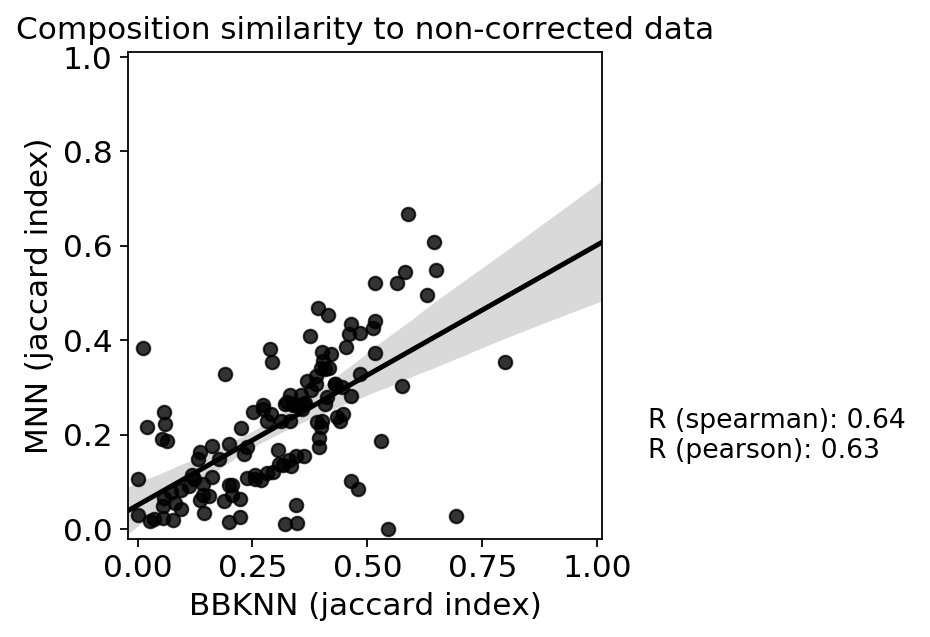

In [22]:

spear_corr = jc.corr(method = 'spearman').iloc[1,0]
pears_corr = jc.corr().iloc[1,0]

plt.figure(figsize = (8,4))
plt.ylim(-0.02, 1.01)
plt.xlim(-0.02, 1.01)

sns.regplot( y = 'MNN', x = 'BBKNN', data = jc, color = 'k',truncate=False)
plt.grid(False)
plt.title('Composition similarity to non-corrected data')
plt.ylabel('MNN (jaccard index)')
plt.xlabel('BBKNN (jaccard index)')


plt.subplots_adjust(right=0.55)
left, right = plt.xlim() 
plt.text(right * 1.1, 0.15,'R (spearman): {} \nR (pearson): {}'.format(round(spear_corr, 2), round(pears_corr, 2)), fontsize=12)
           
plt.savefig('figures/batch_correct_compositional_diff_scatter_jaccard.pdf')
    

## Activity differences

In [23]:
bbknn_auc_mtx_sub = bbknn_auc_mtx[regulon_comp.index]
mnn_auc_mtx_sub = mnn_auc_mtx[regulon_comp.index]
merge_auc_mtx_sub = merge_auc_mtx[regulon_comp.index]

In [24]:
di_r = dict()
for i in regulon_comp.index: 
    di_r[i] = [spearmanr(mnn_auc_mtx_sub[i], merge_auc_mtx_sub[i])[0] ,
             spearmanr(bbknn_auc_mtx_sub[i], merge_auc_mtx_sub[i])[0]]
    

/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [25]:
sp_r = pd.DataFrame(di_r, index = ['MNN', 'BBKNN']).T.sort_values('BBKNN', ascending = False).reset_index()


/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


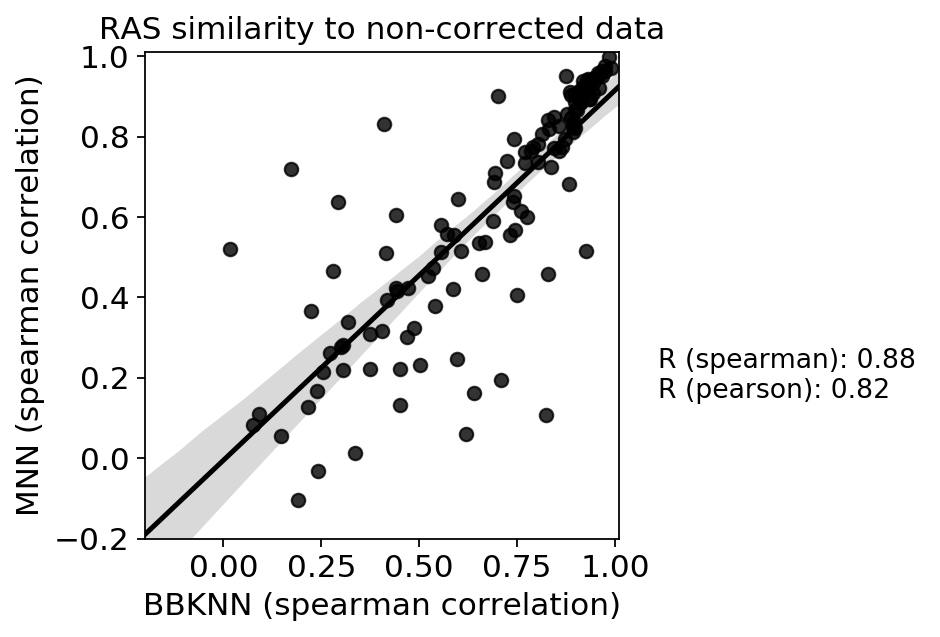

In [26]:

spear_corr = sp_r.corr(method = 'spearman').iloc[1,0]
pears_corr = sp_r.corr().iloc[1,0]

plt.figure(figsize = (8,4))
plt.ylim(-0.2, 1.01)
plt.xlim(-0.2, 1.01)

sns.regplot( y = 'MNN', x = 'BBKNN', data = sp_r, color = 'k')
plt.grid(False)
plt.title('RAS similarity to non-corrected data')
plt.ylabel('MNN (spearman correlation)')
plt.xlabel('BBKNN (spearman correlation)')


plt.subplots_adjust(right=0.55)
left, right = plt.xlim() 
plt.text(right * 1.1, 0.15,'R (spearman): {} \nR (pearson): {}'.format(round(spear_corr, 2), round(pears_corr, 2)), fontsize=12)
           
plt.savefig('figures/batch_correct_RAS_diff_scatter_jaccard.pdf')
    